In [1]:
import csv 
import math 
import statistics 
from collections import Counter
from pathlib import Path

In [2]:
DATA_PATH = Path('C:/Users/Medha/Projects/loan-eligibility-prediction/data/processed/combined_loan_data_processed.csv') 
TARGET_COL = "loan_status"

In [3]:
#Imports and display configuration
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

pd.set_option("display.max_columns", None) 
pd.set_option("display.float_format", lambda x:f"{x:,.3f}")
sns.set_theme(style = "whitegrid", palette = "deep") 

In [4]:
#Load Data 
if not DATA_PATH.exists(): 
    raise FileNotFoundError(f"Could not find dataset at {DATA_PATH}. Please downlaod it and update DATA_PATH.")

loan_df = pd.read_csv(DATA_PATH, low_memory = False) 
print(f"Loaded dataset with {loan_df.shape[0]:,} rows and {loan_df.shape[1]:,} columns") 
loan_df.head()

Loaded dataset with 29,909,442 rows and 15 columns


,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,loan_status,purpose,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,application_type
0,"3,600.000",36 months,13.990,10+ years,MORTGAGE,"55,000.000",Accepted,debt_consolidation,PA,5.91,0.000,675.000,679.000,1.000,Individual
1,"24,700.000",36 months,11.990,10+ years,MORTGAGE,"65,000.000",Accepted,small_business,SD,16.06,1.000,715.000,719.000,4.000,Individual
2,"20,000.000",60 months,10.780,10+ years,MORTGAGE,"63,000.000",Accepted,home_improvement,IL,10.78,0.000,695.000,699.000,0.000,Joint App
3,"35,000.000",60 months,14.850,10+ years,MORTGAGE,"110,000.000",Accepted,debt_consolidation,NJ,17.06,0.000,785.000,789.000,0.000,Individual
4,"10,400.000",60 months,22.450,3 years,MORTGAGE,"104,433.000",Accepted,major_purchase,PA,25.37,1.000,695.000,699.000,3.000,Individual


In [6]:
#Data types and memory footprint 

info = loan_df.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29909442 entries, 0 to 29909441
Data columns (total 15 columns):
 #   Column            Non-Null Count     Dtype  
---  ------            --------------     -----  
 0   loan_amnt         29909409 non-null  float64
 1   term              2260668 non-null   object 
 2   int_rate          2260668 non-null   float64
 3   emp_length        28811147 non-null  object 
 4   home_ownership    2260668 non-null   object 
 5   annual_inc        2260664 non-null   float64
 6   loan_status       29909442 non-null  object 
 7   purpose           2260668 non-null   object 
 8   addr_state        29909387 non-null  object 
 9   dti               29907698 non-null  object 
 10  delinq_2yrs       2260639 non-null   float64
 11  fico_range_low    11411779 non-null  float64
 12  fico_range_high   2260668 non-null   float64
 13  inq_last_6mths    2260638 non-null   float64
 14  application_type  2260668 non-null   object 
dtypes: float64(7), object(8)
memor

In [8]:
#Preview categorical columns with top categories 
categorical_cols = [c for c in loan_df.columns if loan_df[c].dtype == "object"]
summary_rows = []
for col in categorical_cols: 
    unique_vals = loan_df[col].nunique(dropna= False)
    top_values = loan_df[col].value_counts(dropna= False).head(5)
    summary_rows.append({
    "column" : col, 
    "unique_values" : unique_vals, 
    "top_values" : top_values.to_dict()
    })

categorical_summary = pd.DataFrame(summary_rows)
categorical_summary

,column,unique_values,top_values
0,term,3,"{nan: 27648774, ' 36 months': 1609754, ' 60 mo..."
1,emp_length,12,"{'< 1 year': 23184303, '5 years': 2419164, '10..."
2,home_ownership,7,"{nan: 27648774, 'MORTGAGE': 1111450, 'RENT': 8..."
3,loan_status,2,"{'Rejected': 27648741, 'Accepted': 2260701}"
4,purpose,15,"{nan: 27648774, 'debt_consolidation': 1277877,..."
5,addr_state,52,"{'CA': 3556702, 'TX': 2681846, 'FL': 2329575, ..."
6,dti,136991,"{'100%': 1362556, '-1%': 1203063, '0%': 104510..."
7,application_type,3,"{nan: 27648774, 'Individual': 2139958, 'Joint ..."


In [9]:
#Missing-value audit 

missing_counts = loan_df.isna().sum()
missing_pct = missing_counts / len(loan_df) * 100
missing_df = pd.DataFrame({"missing_count": missing_counts, "missing_pct": missing_pct})
missing_df = missing_df[missing_df["missing_count"] > 0].sort_values("missing_pct", ascending = False)

missing_df.head(20)

,missing_count,missing_pct
inq_last_6mths,27648804,92.442
delinq_2yrs,27648803,92.442
annual_inc,27648778,92.442
int_rate,27648774,92.442
home_ownership,27648774,92.442
term,27648774,92.442
application_type,27648774,92.442
purpose,27648774,92.442
fico_range_high,27648774,92.442
fico_range_low,18497663,61.846


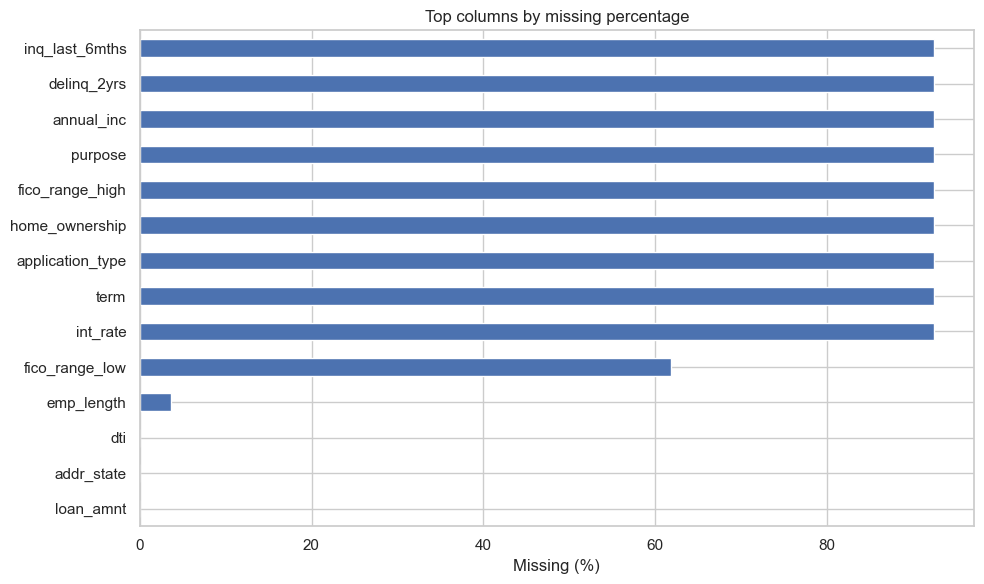

In [10]:
#Visualize missingness for top columns 
plt.figure(figsize = (10,6))
missing_df.head(30)["missing_pct"].sort_values().plot(kind ="barh")
plt.xlabel("Missing (%)")
plt.title("Top columns by missing percentage")
plt.tight_layout()
plt.show()

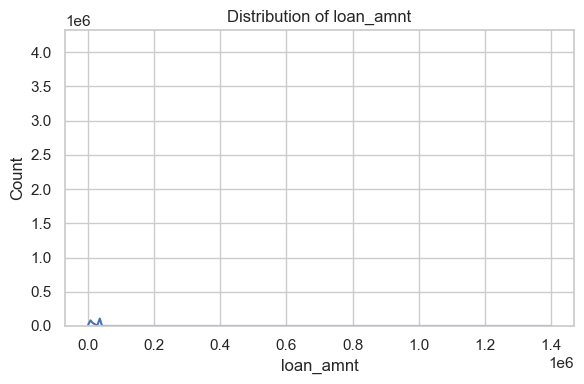

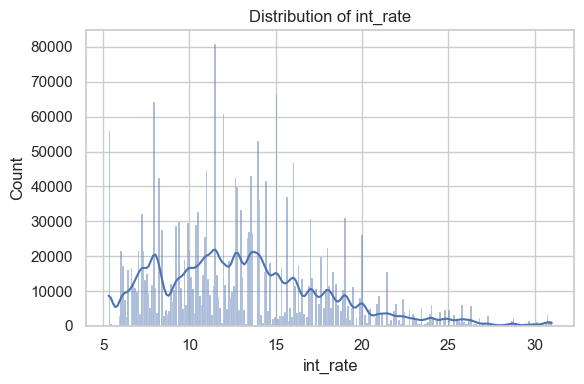

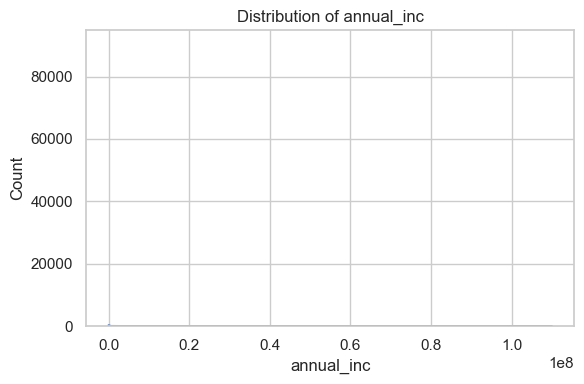

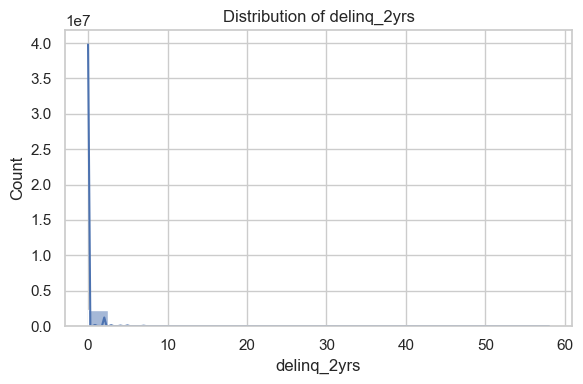

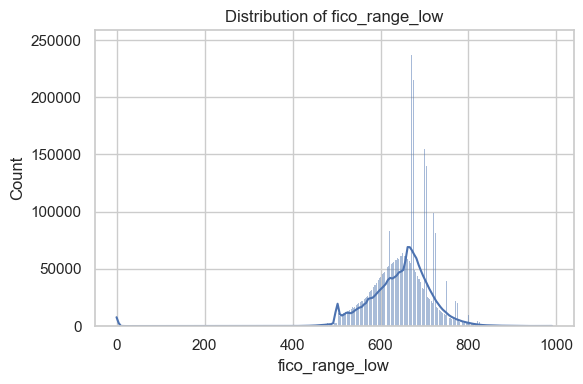

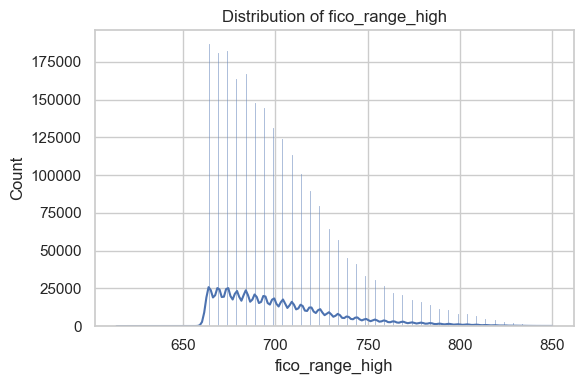

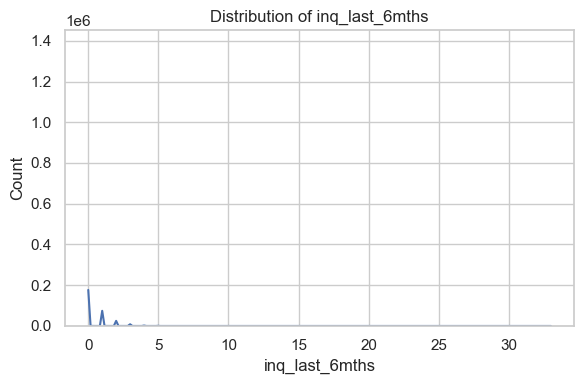

In [11]:
#Numerical distributions 

numeric_cols = loan_df.select_dtypes(include = [np.number]).columns.tolist()

for col in numeric_cols: 
    fig, ax = plt.subplots(figsize = (6,4))
    sns.histplot(loan_df[col].dropna(), kde = True, ax = ax) 
    ax.set_title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()

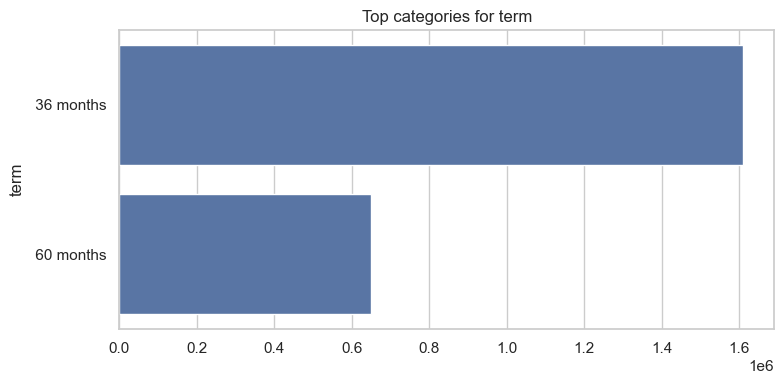

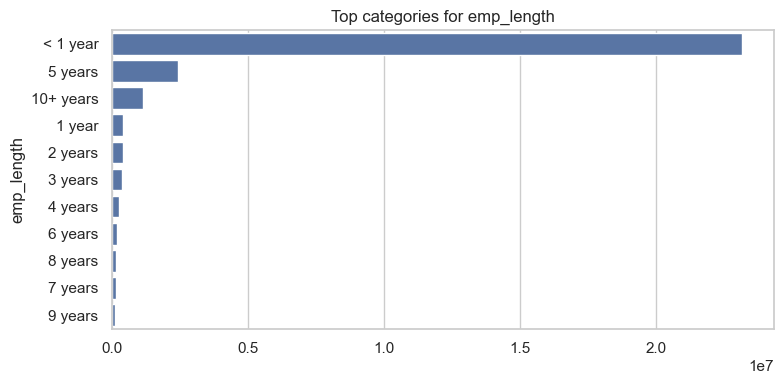

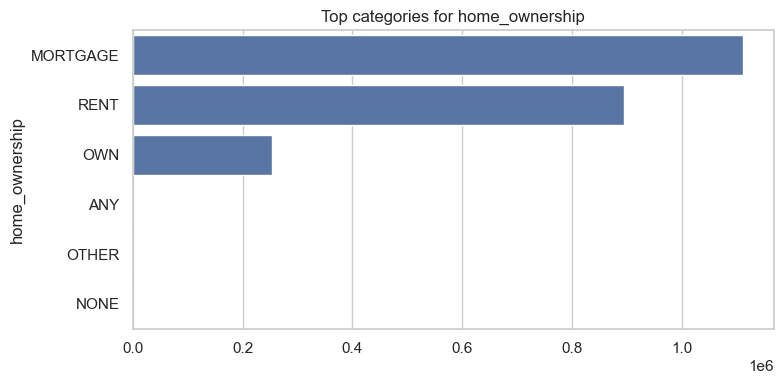

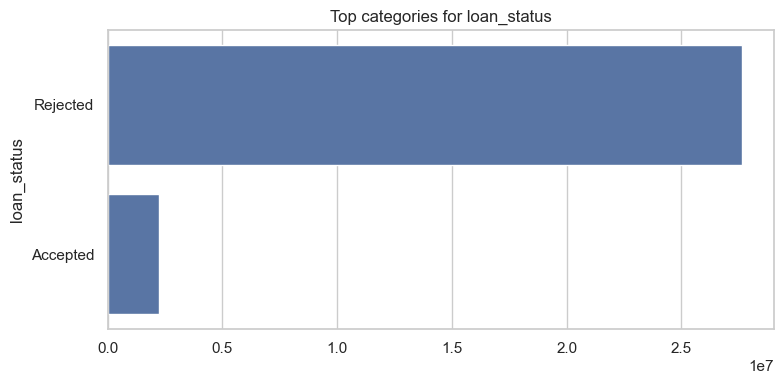

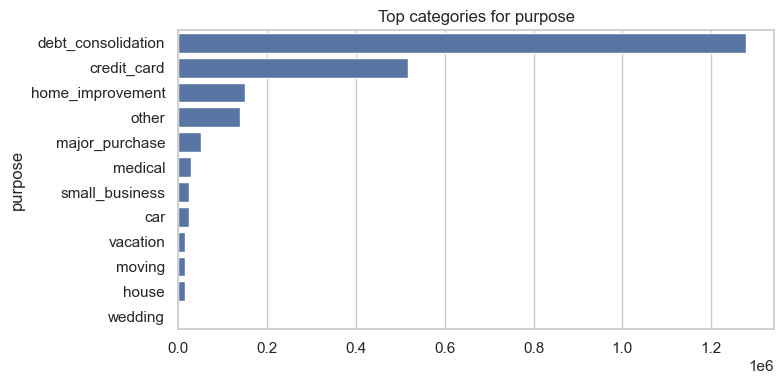

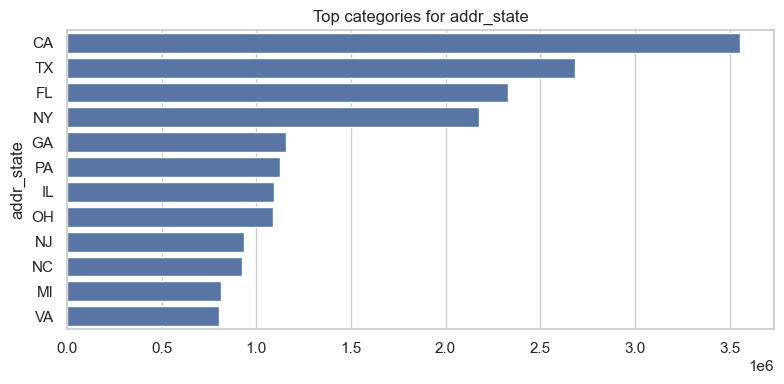

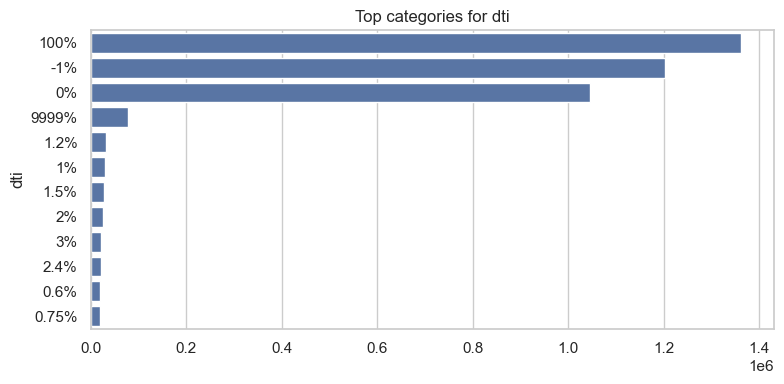

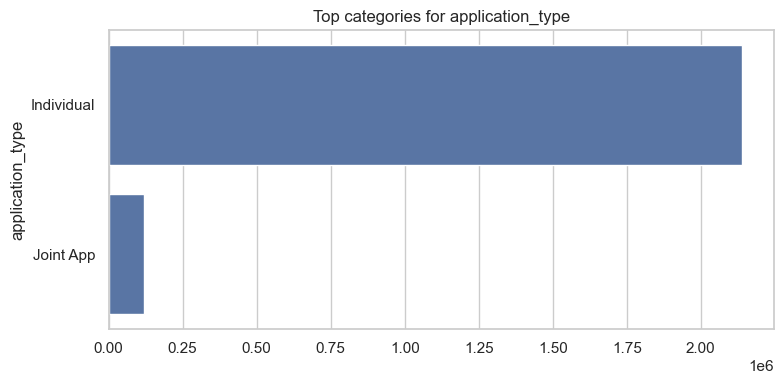

In [12]:
#Categorical distributions (top 12 categories per feature)

for col in categorical_cols: 
    fig, ax = plt.subplots(figsize = (8,4))
    top_counts = loan_df[col].value_counts().head(12)
    sns.barplot(x = top_counts.values, y = top_counts.index, ax = ax) 
    ax.set_title(f"Top categories for {col}")
    plt.tight_layout()
    plt.show()

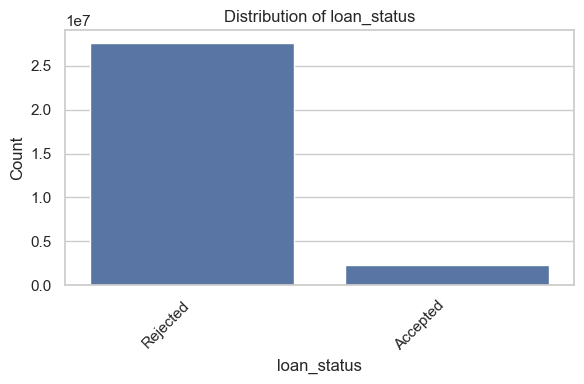

In [13]:
#Target Distribution 

if TARGET_COL and TARGET_COL in loan_df.columns: 
    fig, ax = plt.subplots(figsize = (6,4))
    target_counts = loan_df[TARGET_COL].value_counts(dropna = False)
    sns.barplot(x = target_counts.index.astype(str), y = target_counts.values, ax = ax) 
    ax.set_title(f"Distribution of {TARGET_COL}") 
    ax.set_ylabel("Count")
    plt.xticks(rotation = 45, ha = "right") 
    plt.tight_layout()
    plt.show()

else: 
    print("TARGET_COL not set or missing from dataframe; skipping target checks.") 

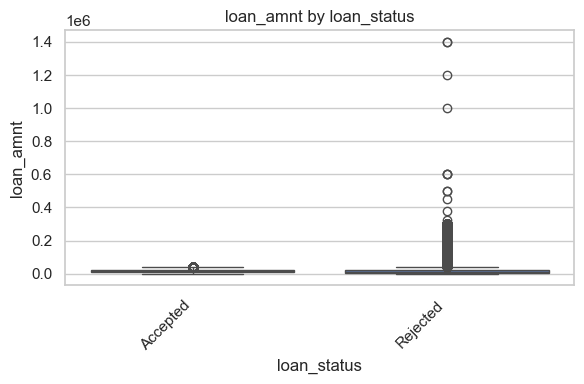

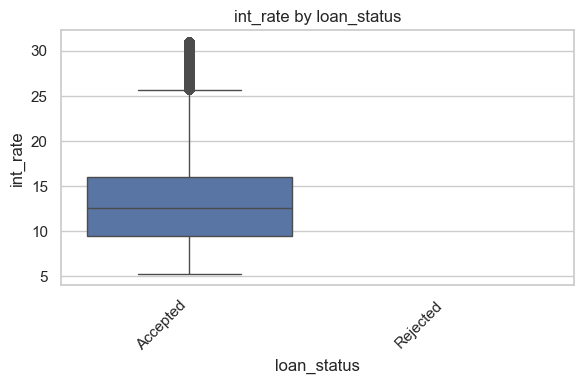

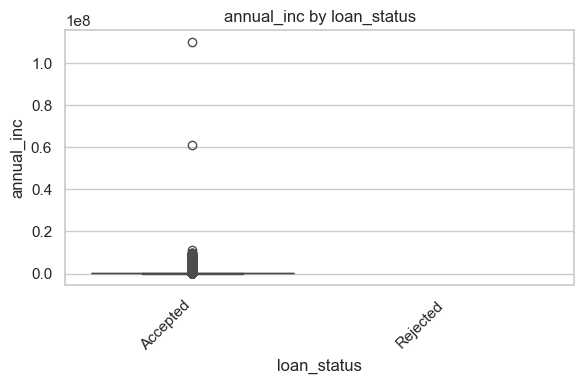

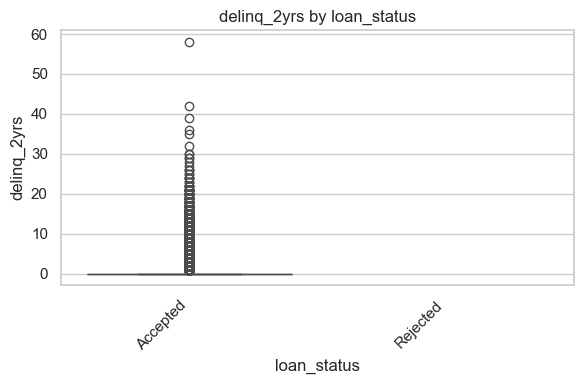

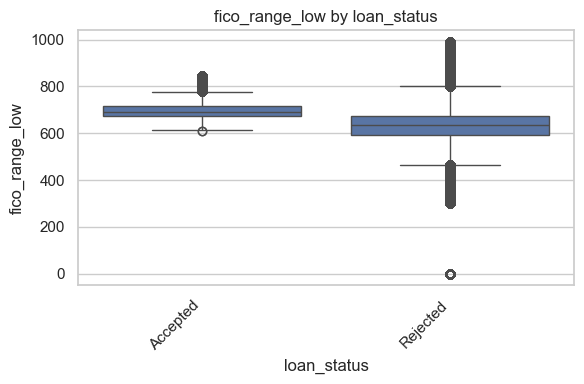

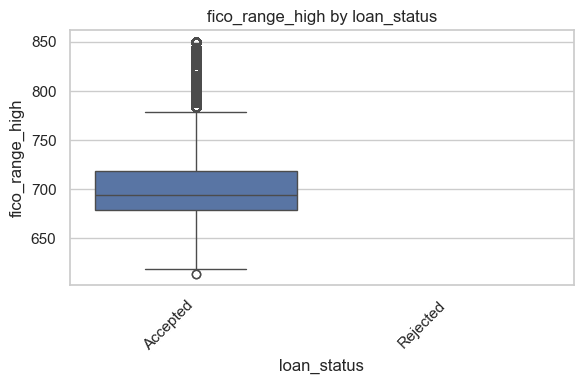

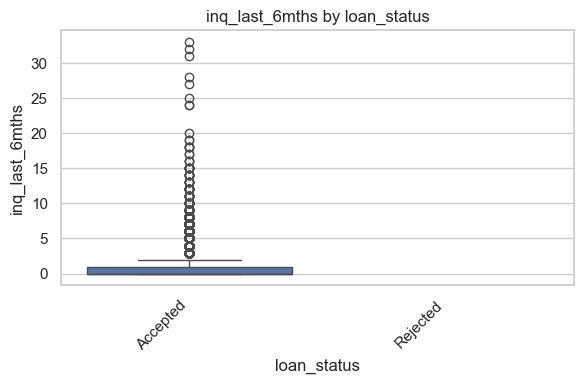

In [14]:
#Numeric features vs. target (boxplots) 

if TARGET_COL and TARGET_COL in loan_df.columns: 
    for col in numeric_cols: 
        fig, ax = plt.subplots(figsize = (6,4))
        sns.boxplot(data = loan_df, x = TARGET_COL, y = col, ax = ax) 
        ax.set_title(f"{col} by {TARGET_COL}") 
        plt.xticks(rotation = 45, ha = "right") 
        plt.tight_layout()
        plt.show()

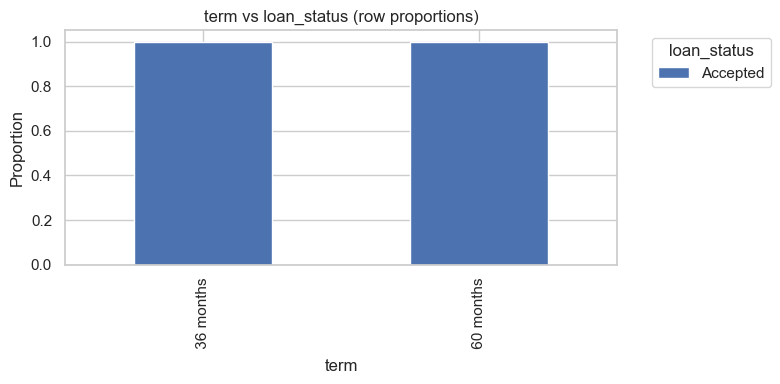

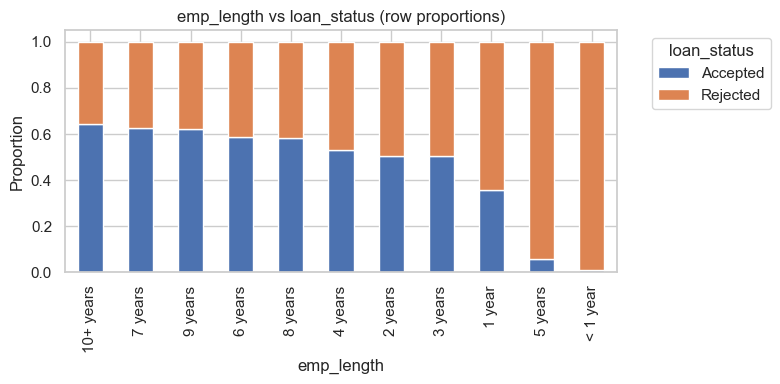

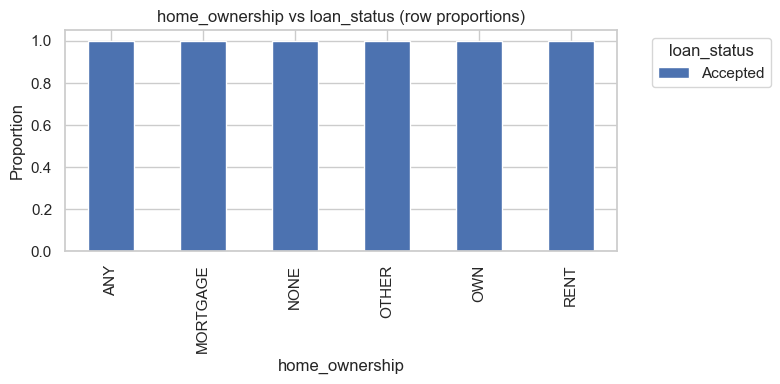

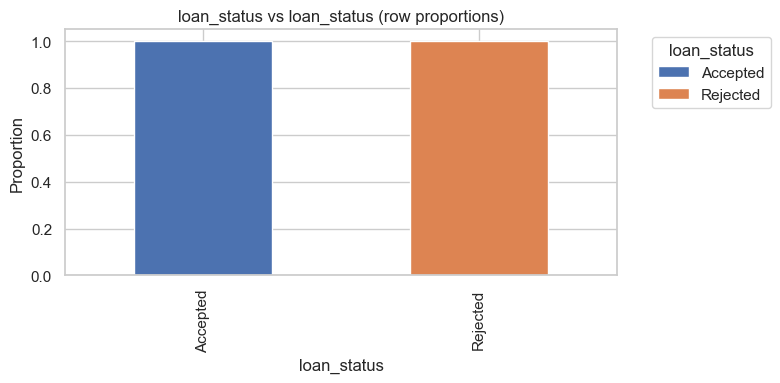

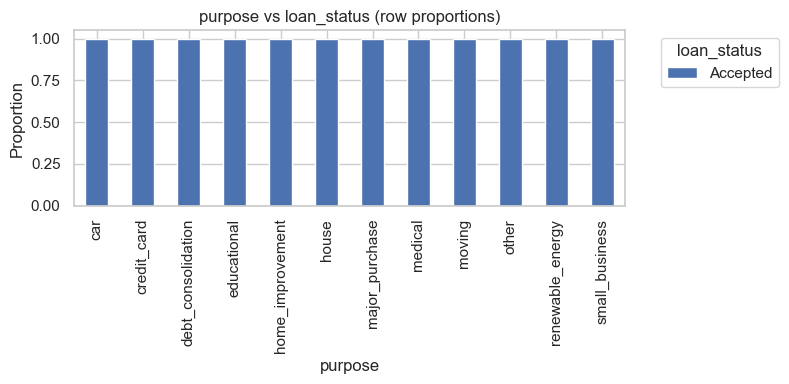

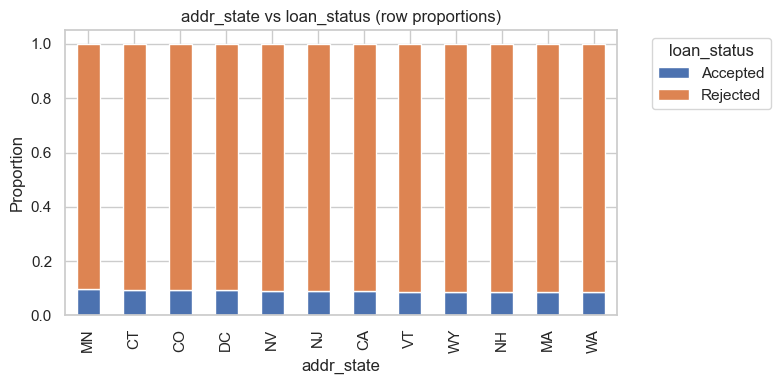

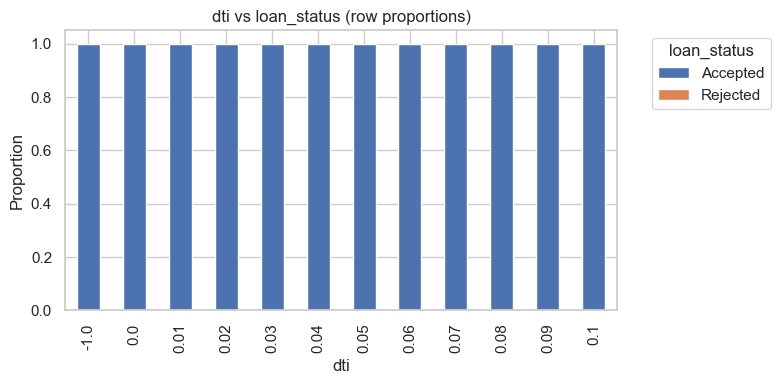

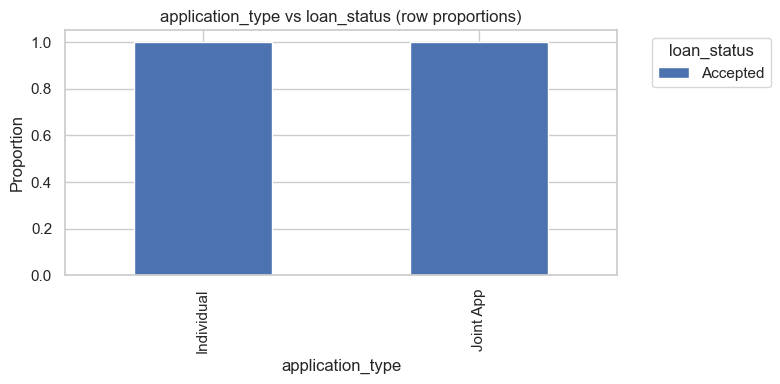

In [15]:
#Categorical features vs target (stacked proportions) 

if TARGET_COL and TARGET_COL in loan_df.columns: 
    for col in categorical_cols: 
        ct = pd.crosstab(loan_df[col], loan_df[TARGET_COL], normalize = "index")
        ct = ct.sort_values(by = ct.columns.tolist(), ascending = False) 
        ct.head(12).plot(kind = "bar", stacked = True, figsize = (8,4))
        plt.title(f"{col} vs {TARGET_COL} (row proportions)") 
        plt.ylabel("Proportion") 
        plt.legend(title = TARGET_COL, bbox_to_anchor = (1.05, 1) , loc = "upper left") 
        plt.tight_layout()
        plt.show()

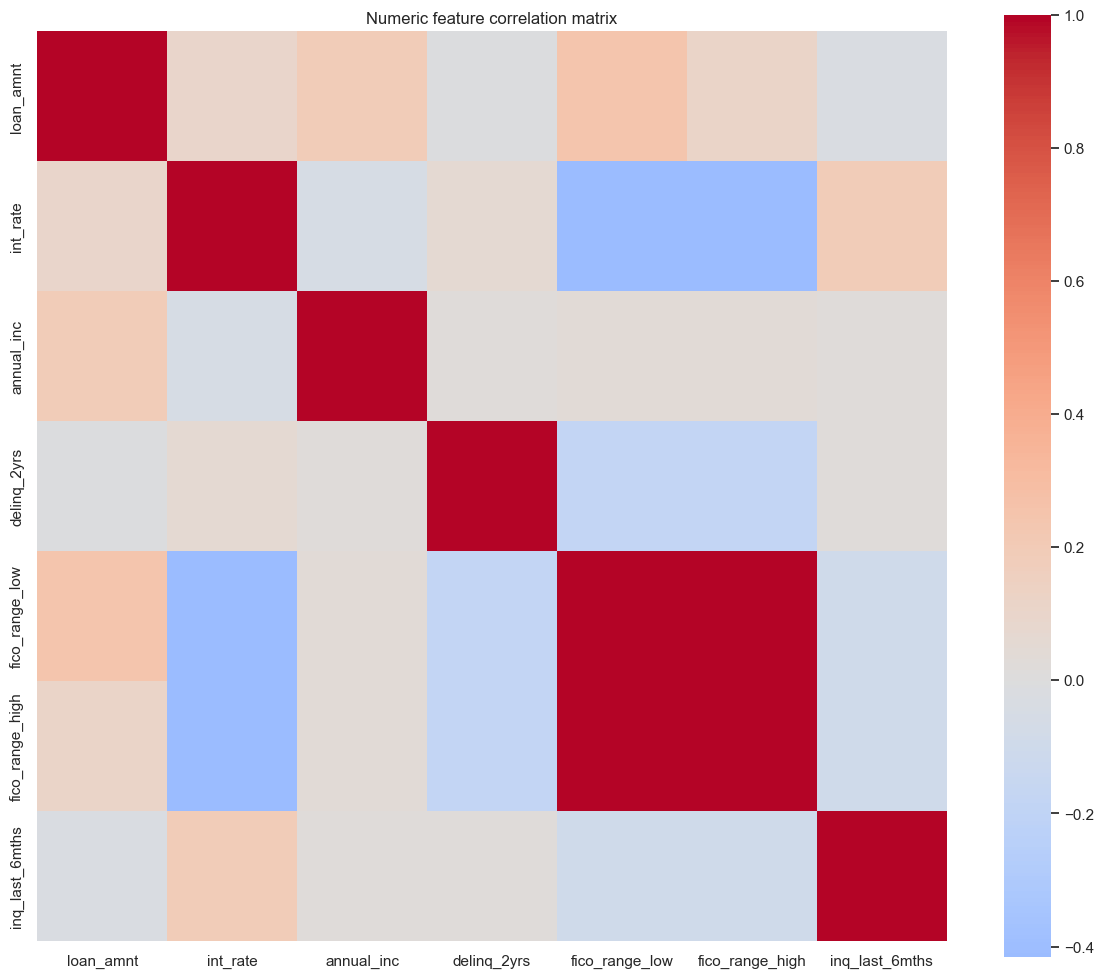

In [16]:
#Correlations and multicollinearity 

if numeric_cols: 
    corr = loan_df[numeric_cols].corr(numeric_only = True) 
    plt.figure(figsize = (12,10))
    sns.heatmap(corr, cmap = "coolwarm", center = 0, square = True) 
    plt.title("Numeric feature correlation matrix") 
    plt.tight_layout()
    plt.show()

In [17]:
#Outlier inspection (IQR rule) 

from collections import defaultdict 

iqr_stats = defaultdict(dict) 
for col in numeric_cols: 
    q1 = loan_df[col].quantile(0.25) 
    q3 = loan_df[col].quantile(0.75) 
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    outliers = loan_df[(loan_df[col] < lower) | (loan_df[col] > upper)] 
    iqr_stats[col] = { 
    "q1" : q1, 
    "q3" : q3, 
    "iqr" : iqr, 
    "lower" : lower, 
    "upper" : upper, 
    "outlier_count" : len(outliers), 
    "outlier_pct" : len(outliers) / len(loan_df) * 100, 
    } 
iqr_df = pd.DataFrame(iqr_stats).T.sort_values("outlier_pct",ascending = False) 
iqr_df.head(15) 

,q1,q3,iqr,lower,upper,outlier_count,outlier_pct
delinq_2yrs,0.000,0.000,0.000,0.000,0.000,"421,531.000",1.409
fico_range_low,605.000,689.000,84.000,479.000,815.000,"204,245.000",0.683
loan_amnt,"5,000.000","20,000.000","15,000.000","-17,500.000","42,500.000","178,627.000",0.597
annual_inc,"46,000.000","93,000.000","47,000.000","-24,500.000","163,500.000","110,041.000",0.368
inq_last_6mths,0.000,1.000,1.000,-1.500,2.500,"94,314.000",0.315
fico_range_high,679.000,719.000,40.000,619.000,779.000,"74,846.000",0.250
int_rate,9.490,15.990,6.500,-0.260,25.740,"41,099.000",0.137


In [18]:
#Save missingness and outlier summaries to disk (helpful for reporting) 
output_dir = Path("artifacts") 
output_dir.mkdir(exist_ok = True) 

missing_df.to_csv(output_dir / "missingness_summary.csv") 
iqr_df.to_csv(output_dir / "iqr_outlier_summary.csv") 
print("Saved summaries to:") 
print(output_dir /"missingness_summary.csv") 
print(output_dir /"iqr_outlier_summary.csv") 

Saved summaries to:
artifacts\missingness_summary.csv
artifacts\iqr_outlier_summary.csv
